<a href="https://colab.research.google.com/github/samarth-mistry/arima-forcasting/blob/main/AH_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## POC sarimax

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
%matplotlib inline

DF2 261
DF3 261


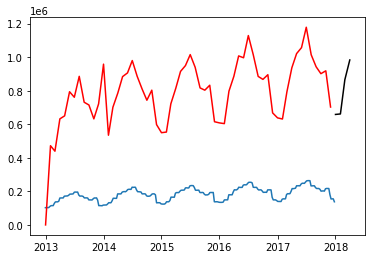

In [ ]:
def load_clean_data(freq):
  ori_df = pd.read_csv('https://raw.githubusercontent.com/samarth-mistry/csv-data/main/ah/train.csv')
  # ori_df = ori_df.iloc[-721:,:]
  if freq == 'M':
    ori_df.date = ori_df.date.apply(lambda x: str(x)[:-3])
    ori_df = ori_df.groupby('date')['sales'].sum().reset_index()
  else:
    ori_df['date'] = pd.to_datetime(ori_df['date']) - pd.to_timedelta(7, unit='d')
    ori_df = ori_df.groupby(pd.Grouper(key='date', freq='W-MON'))['sales'].sum().reset_index().sort_values('date')
    # ori_df = ori_df.iloc[-104:,:]

  ori_df.date = pd.to_datetime(ori_df.date)
  df2 = ori_df.set_index('date')
  seasonal_info = seasonal_decompose(df2['sales'], model='multiplicative')

  # model = SARIMAX(df2['sales'], order=(5,1,3), seasonal_order=(1,1,1,12))
  # model_fit = model.fit()
  residuals_info = model_fit.resid
  # residuals_info.plot()
  print("DF2",len(df2))

  return df2, seasonal_info, residuals_info

def plot_results(df3,yhat,forecast):
  plt.plot(df3['sales'])
  plt.plot(yhat, color='red')
  plt.plot(forecast, color='black')

def automation(number_of_month, freq):
  df3, seasonal_info, residuals_info = load_clean_data(freq)
  print("DF3",len(df3))
  forecast = model_fit.forecast(number_of_month)
  yhat = model_fit.predict()

  plot_results(df3,yhat,forecast)

automation(4,'W')

NameError: ignored

DF2 60
DF3 60


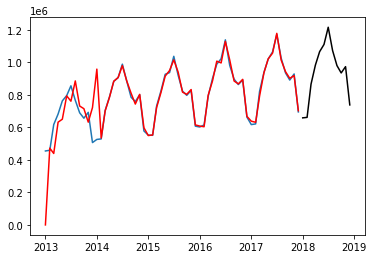

In [ ]:
automation(12,'M')

In [ ]:
ori = load_data()
ori = ori.iloc[-720:,:]
ori

,date,store,item,sales
912280,2016-01-12,10,50,62
912281,2016-01-13,10,50,52
912282,2016-01-14,10,50,68
912283,2016-01-15,10,50,61
912284,2016-01-16,10,50,67
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


261
        date   sales
0 2012-11-12  102836
1 2012-11-19  103879
2 2012-11-26  102913
3 2012-12-03  103437
4 2012-12-10  110177
104
          date   sales
157 2015-11-16  134472
158 2015-11-23  134589
159 2015-11-30  134534
160 2015-12-07  136305
161 2015-12-14  149125


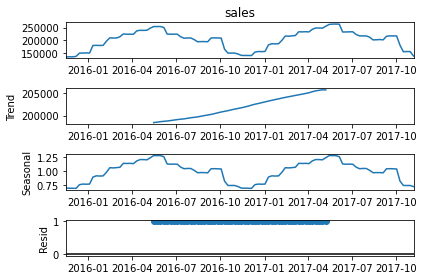

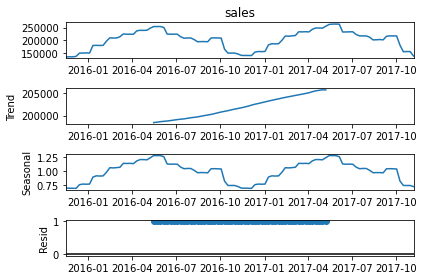

In [ ]:
df=ori
df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
df = df.groupby(pd.Grouper(key='date', freq='W-MON'))['sales'].sum().reset_index()
print(len(df))
print(df.head())
df = df.iloc[-104:,:]
print(len(df))
print(df.head())
df.date = pd.to_datetime(df.date)
df2 = df.set_index('date')
seasonal_info = seasonal_decompose(df2['sales'], model='multiplicative')
seasonal_info.plot()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import statsmodels.tsa.api as smt
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
%matplotlib inline

def load_data():
    return pd.read_csv('https://raw.githubusercontent.com/samarth-mistry/csv-data/main/ah/train.csv')

def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data

def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    return data

def generate_supervised(data):
    supervised_df = data.copy()
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    supervised_df = supervised_df.dropna().reset_index(drop=True)
    return supervised_df

def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    dt_data.to_csv('arima_df.csv')
    return dt_data

def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    return train, test

def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    return X_train, y_train, X_test, y_test, scaler

def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)  #reshape y_pred
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))

    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted


def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    print(sales_dates)
    act_sales = list(original_df[-13:].sales)

    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result


model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

def plot_results(original_df, results, model_name):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, label='Predicted', color='Red')

    ax.set(xlabel = "Date", ylabel = "Sales", title = f"{model_name} Sales Forecasting Prediction")
    ax.legend()
    sns.despine()
    # plt.savefig(f'{model_name}_forecast.png')


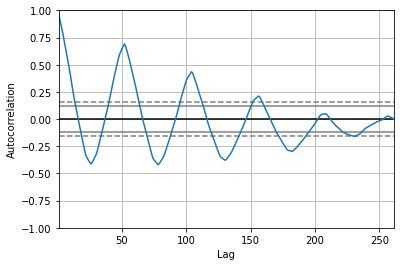

In [ ]:
from pandas.plotting import autocorrelation_plot
ori_df = load_data()
ori_df['date'] = pd.to_datetime(ori_df['date']) - pd.to_timedelta(7, unit='d')
ori_df = ori_df.groupby(pd.Grouper(key='date', freq='W-MON'))['sales'].sum().reset_index().sort_values('date')
autocorrelation_plot(ori_df['sales'])

## AI code automation

In [ ]:
!pip install flask-restful
!pip install Flask-Cors==1.10.3
!pip install nest-asyncio
!pip install pyngrok
!ngrok authtoken 2IP7PalV81s43Rw84kJHG66UZxm_81MQcg3ps9kEL9CSWJhrT

import nest_asyncio
from pyngrok import ngrok
from flask import request, Flask, Response, json
from flask_restful import Resource, Api, reqparse
from flask_cors import CORS
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for Flask-Cors: filename=Flask_Cors-1.10.3-py3-none-any.whl size=11548 sha256=e7e31012947a677bb5aa5178114206b9618ed24b67ed623f4a75405e363ee9df
  Stored in directory: /root/.cache/pip/wheels/d6/60/32/124c021589ed14e4c43b804528b8a823388f710ec8615fa4af
Successfully built Flask-Cors
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.

In [ ]:
# from fastapi import FastAPI, Request
app = Flask(__name__)
CORS(app)
api = Api(app)

def forecast_interpolation(freq, ll,interp):
  if interp:
    try:
      fdf = pd.DataFrame({'date':ll.index, 'sales':ll.values})
      start_d = ll.index[0]
      end_d = ll.index[len(ll)-1]
      dates = pd.date_range(str(start_d), str(end_d), freq='D')
      ts = pd.DataFrame(fdf['sales'], index=dates)
      ts.reset_index(level=0, inplace=True)
      fdf = ts.set_index('index').join(fdf.set_index('date'), how='left', lsuffix='_left', rsuffix='_right')
      fdf = fdf.drop(['sales_left'],axis=1)
      if freq == 'M':
        fdf['sales_right'] = fdf['sales_right']/30
      else:
        fdf['sales_right'] = fdf['sales_right']/7

      fdf = fdf['sales_right'].interpolate(method='quadratic')

      return pd.DataFrame({'date':fdf.index.strftime('%Y-%m-%d'), 'sales':fdf.values})
    except:
      return pd.DataFrame({'date':ll.index.strftime('%Y-%m-%d'), 'sales':ll.values})

  return pd.DataFrame({'date':ll.index.strftime('%Y-%m-%d'), 'sales':ll.values})


def forcast_automation(number_of_month, freq,interp, n=30):
  ori_df = pd.read_csv('https://raw.githubusercontent.com/samarth-mistry/csv-data/main/ah/train.csv')
  if freq == 'M':
    ori_df.date = ori_df.date.apply(lambda x: str(x)[:-3])
    ori_df = ori_df.groupby('date')['sales'].sum().reset_index()
  else:
    ori_df['date'] = pd.to_datetime(ori_df['date']) - pd.to_timedelta(7, unit='d')
    ori_df = ori_df.groupby(pd.Grouper(key='date', freq='W-MON'))['sales'].sum().reset_index().sort_values('date')

  ori_df.date = pd.to_datetime(ori_df.date)
  df2 = ori_df.set_index('date')
  df3 = pd.DataFrame({'date':df2.index.strftime('%Y-%m-%d'), 'sales':df2['sales']})
  seasonal_info = seasonal_decompose(df2['sales'], model='multiplicative')

  if freq == 'M':
    model = SARIMAX(df2['sales'], order=(5,1,3), seasonal_order=(1,1,1,12)) #months
  else:
    model = SARIMAX(df2['sales'], order=(9,0,1), seasonal_order=(1,1,1,12)) #weeks

  model_fit = model.fit()
  residuals_info = model_fit.resid
  forecast = model_fit.forecast(number_of_month)
  forecast = forecast_interpolation(freq,forecast,interp)

  # n = 20
  df3= df3.tail(int(len(df3)*(n/100)))

  return df3.to_dict(orient='records'), forecast.to_dict(orient='records'), None , None


class Forecast(Resource):
  def get(self):

    upto = request.args.get('upto')
    freq = request.args.get('freq')
    interp = request.args.get('interp')

    ori_df, forecast, seasn, recid = forcast_automation(int(upto),freq,int(interp))

    resp = {
        "ori_data": ori_df,
        "forecast": forecast,
        "seasonality": seasn,
        "recidual": recid,
        "autocorrelation_plot":None

    }
    return Response(response=json.dumps(resp), status=200, mimetype="application/json")


api.add_resource(Forecast, '/get-forecast')

ngrok_tunnel = ngrok.connect(5001)
print(ngrok_tunnel)
# try:
# print(ngrok_tunnel+"/get-forecast?upto=5&freq=W&interp=1")
nest_asyncio.apply()
app.run(host="0.0.0.0", port="5001")
# except Exception as e:
  # print("EXP",e)
  # ngrok.disconnect(ngrok_tunnel)

NgrokTunnel: "https://62bd-35-231-168-237.ngrok-free.app" -> "http://localhost:5001"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://172.28.0.12:5001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [25/Apr/2023 04:24:45] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [25/Apr/2023 04:24:46] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [25/Apr/2023 04:26:07] "GET /get-forecast?upto=5&freq=M&interp=0 HTTP/1.1" 200 -
